In [ ]:
!git clone https://github.com/ViktorAnchutin/detecting_active_emotion.git;
!mv detecting_active_emotion/* .

In [ ]:
!pip install transformers --quiet;
!pip install timm --quiet;

import pandas as pd
from functools import partial
from itertools import chain
import torch
from torch import nn
import gc
from data.utils import *
from transformers import Wav2Vec2Model
from experiments.models import W2V2Model, ConvNextModel
from data.dataloader import create_dataloader, MultiDataLoader
from framework.learning_rate import ExponentialLRCalculator,CosineLRCalculator
from experiments.experiment_runner import Training, TrainingConfig
from matplotlib import pyplot as plt
import torchaudio
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
w2v_features_path = 'w2v_features'

# Annotations preprocessing

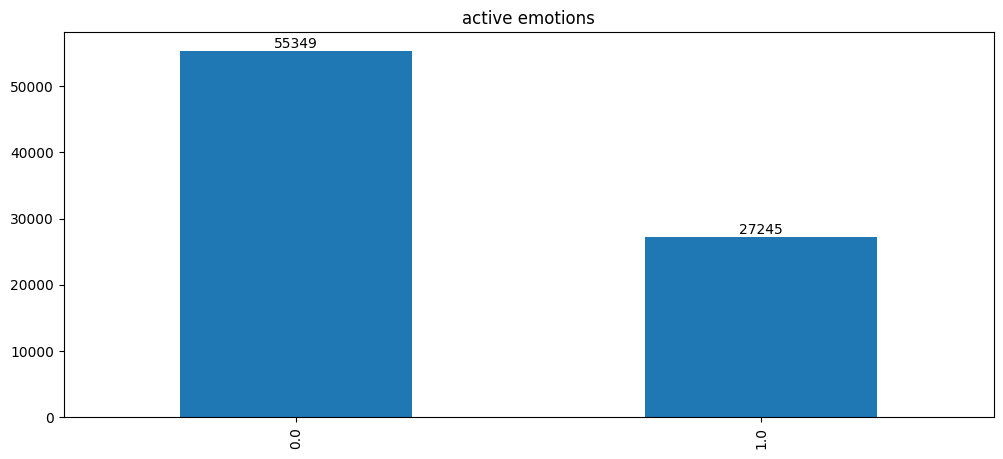

In [ ]:
data = pd.read_csv("labels_consensus.csv").set_index("FileName")
data = data[data.SpkrID != 'Unknown']
data['is_active'] = data.apply(lambda x: 1. if x['EmoAct'] >= 5 else 0.,axis=1)

def plot_label(data,label,ax=None,title=None):
  barc = data[label].value_counts().plot.bar(ax=ax,title=title)
  barc.bar_label(barc.containers[0], label_type='edge')

_,ax = plt.subplots(1,figsize=(12, 5));
plot_label(data, 'is_active',ax=ax, title='active emotions');

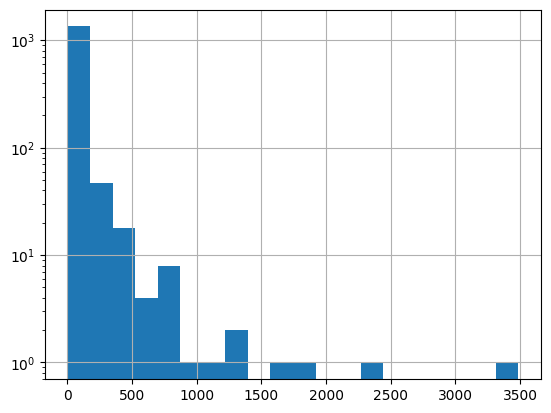

In [ ]:
speaker_counts = data.groupby('SpkrID').apply(lambda x: pd.Series({'cnt':len(x)}))
speaker_counts.cnt.hist(log=True,bins=20);

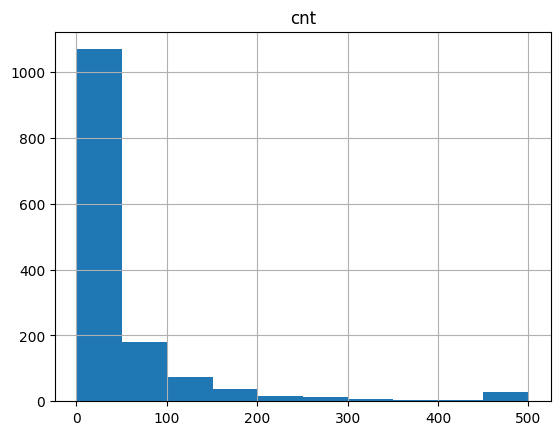

In [ ]:
def downsample_speaker(data,speaker,limit=500):
  sampled_ids = data[data['SpkrID'] == speaker].sample(limit).index
  todrop = data[(data['SpkrID'] == speaker)&(~data.index.isin(sampled_ids))].index
  return data.drop(todrop)

for sid in speaker_counts[speaker_counts.cnt >= 500].index:
  data = downsample_speaker(data,sid)

data.groupby('SpkrID').apply(lambda x: pd.Series({'cnt':len(x)})).hist();

,unique speakers
custom_partition,
Test,286
Train,1146


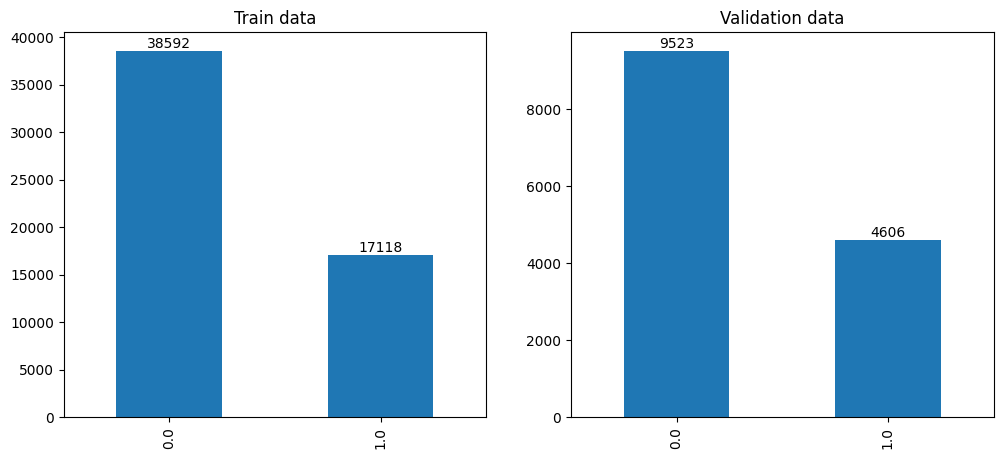

In [ ]:
speakers = data.SpkrID.value_counts()

holdout_speakers = speakers.sample(round(len(speakers)*0.2), random_state=123)
data.loc[:,'custom_partition'] = data.apply(lambda x: 'Test' if x['SpkrID'] in holdout_speakers.index else 'Train', axis=1)

train_data = data[data.custom_partition == 'Train']
valid_data = data[data.custom_partition == 'Test']

_,ax = plt.subplots(1,2,figsize=(12, 5));
plot_label(train_data, 'is_active', ax=ax[0], title='Train data');
plot_label(valid_data, 'is_active', ax=ax[1], title='Validation data');

data.groupby('custom_partition').apply(lambda x: pd.Series({'unique speakers':len(x.SpkrID.unique())}))

## Collect information about duration

In [ ]:
files = []
durations = []
samples = []

for file_name in tqdm(data.index):
      signal, sr = torchaudio.load(f"Audios/Audio/{file_name}")
      files.append(file_name)
      durations.append(signal.shape[1]/sr)
      samples.append(signal.shape[1])

100%|██████████| 69839/69839 [15:57<00:00, 72.92it/s]


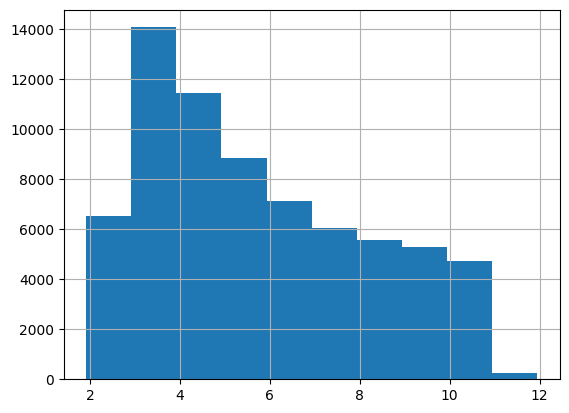

In [ ]:
duration_df = pd.DataFrame({"file":files, "samples":samples, "dur":durations}).set_index('file')
train_data = train_data.join(duration_df)
valid_data = valid_data.join(duration_df)
duration_df.dur.hist();

In [ ]:
bins=20

train_data['bin'] = pd.cut(train_data.dur, bins=bins, labels=range(bins))
train_data.loc[train_data['bin']==19, 'bin'] = 18 # merge last bin due to only one record

valid_data['bin'] = pd.cut(valid_data.dur, bins=bins, labels=range(bins))

In [ ]:
weight = len(train_data[train_data['is_active'] == 0])/len(train_data[train_data['is_active'] == 1])

# Precompute w2v features

W2v convolutional encoder consumes a lot of GPU. To avoid it during training, the features are precomputed.

In [ ]:
audios_mean,audios_sdt = (-0.00011539726044066538, 0.07812332811748154)
raw_audio_datasets_train = create_binned_datasets(train_data, partial(create_audio_ds, norms=(audios_mean,audios_sdt)))
raw_audio_datasets_valid = create_binned_datasets(valid_data, partial(create_audio_ds, norms=(audios_mean,audios_sdt)))

w2v_feature_extractor = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").feature_extractor


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!mkdir {w2v_features_path}

for ds in chain(raw_audio_datasets_train, raw_audio_datasets_valid):
  extract_w2v_features(ds, w2v_feature_extractor, w2v_features_path, bs=32, device=device)

100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


# Spectrograms fixed length dataset

In [ ]:
window = 640 # 40ms
hop = 320 # 20 ms
mels=64
maxl = max(get_max_spectrogram_length(train_data,hop), get_max_spectrogram_length(valid_data,hop))
print(f'maxl {maxl}')
spctr_norms = (-5.612719667630828, 12.146062730351977)

maxl 555


In [ ]:
spctr_dataset_train_fixed = create_spectrogram_ds(train_data, maxl=maxl,norms=spctr_norms,w=window,hop=hop,n_mels=mels)
spctr_dataset_valid_fixed = create_spectrogram_ds(valid_data, maxl = maxl,norms=spctr_norms,w=window,n_mels=mels)

#Spectrograms binned datasets

In [ ]:
window = 640 # 40ms
hop = 320 # 20 ms
mels=64
spctr_binned_dataset_norms = (-10.58189139511126, 14.482822057824656)
spctr_dataset_builder = partial(create_spectrogram_ds,norms=spctr_binned_dataset_norms,w=window,hop=hop,n_mels=mels)
spctr_ds_train_binned = create_binned_datasets(train_data, spctr_dataset_builder)
spctr_ds_valid_binned = create_binned_datasets(valid_data, spctr_dataset_builder)

# W2V datasets binned

In [ ]:
w2v2_datasets_train = create_binned_datasets(train_data, partial(create_file_ds, path=w2v_features_path))
w2v2_datasets_valid = create_binned_datasets(valid_data, partial(create_file_ds, path=w2v_features_path))

#Hybrid

In [ ]:
from data.utils import create_hybrid_datasets_binned
from data.dataloader import collate_hybrid

In [ ]:
hybrid_datasets_train = create_hybrid_datasets_binned(w2v2_datasets_train, spctr_ds_train_binned)
hybrid_datasets_valid = create_hybrid_datasets_binned(w2v2_datasets_valid, spctr_ds_valid_binned)

In [ ]:
hybrid_dl_train = MultiDataLoader(hybrid_datasets_train, partial(create_dataloader, collate_fn=collate_hybrid, bs=8))
hybrid_dl_valid = MultiDataLoader(hybrid_datasets_valid, partial(create_dataloader, collate_fn=collate_hybrid, bs=8))

In [ ]:
for ds in chain(hybrid_datasets_train,hybrid_datasets_valid):
  ds.prefetch(1)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1775/1775 [03:54<00:00,  7.57it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.847191,0.816372,0.766683,0.607242,0.71805,0.526062


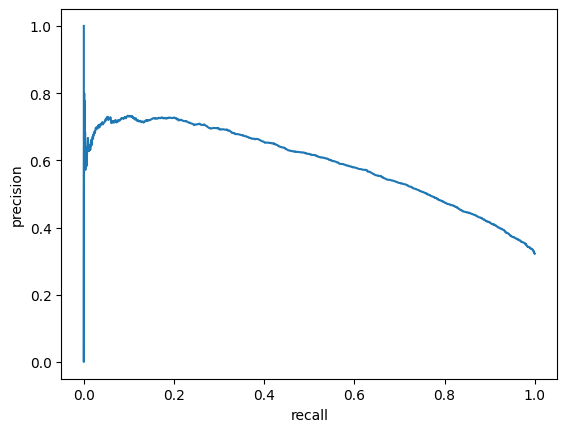

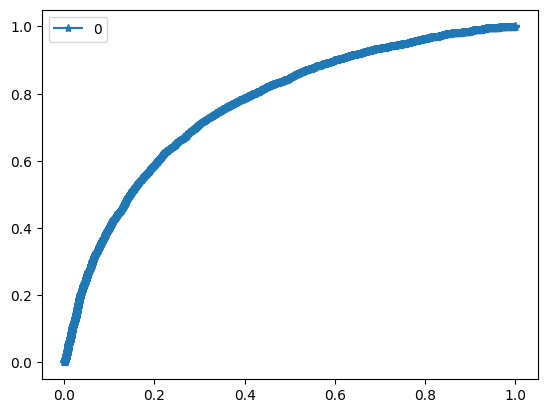

100%|██████████| 1775/1775 [04:00<00:00,  7.39it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.769939,0.750812,0.82529,0.659073,0.71783,0.609206


100%|██████████| 1775/1775 [04:01<00:00,  7.34it/s]


,train_loss,test_loss,auc,f1,recall,precision
1,0.712602,0.732861,0.821689,0.658245,0.75516,0.583376


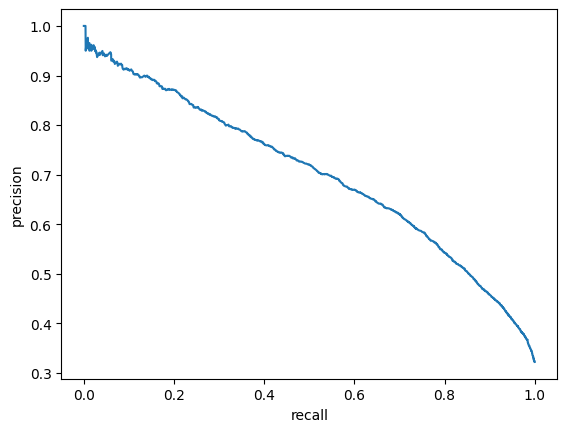

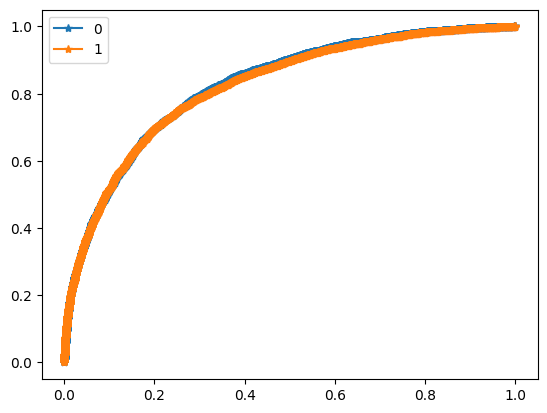

In [ ]:
from experiments.models import HybridModel, ConvNextModel

spctr_model = ConvNextModel(name = 'convnext_tiny')
model = HybridModel(spctr_model=spctr_model)

hybrid_training_config = TrainingConfig(
    fine_tune = True,
    device = device,
    model = model,
    train_dl = hybrid_dl_train,
    valid_dl = hybrid_dl_valid,
    optimizer = torch.optim.AdamW,
    weight_decay = 1,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 2,
    head_pretrain_epochs = 1,
    learning_rate = 1e-5,
    head_pretrain_learning_rate = 1e-3,
    mixed_precision = True,
    gradient_accumulation_size = 64
)

training = Training(hybrid_training_config)

training.run()

In [ ]:
errors_report = training.trainer.cbs.callbacks[-3].get_errors_report()
errors_report.to_csv('errors_report.csv')

# W2V

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 892/892 [02:42<00:00,  5.50it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.932333,0.92618,0.65685,0.512447,0.671278,0.414396


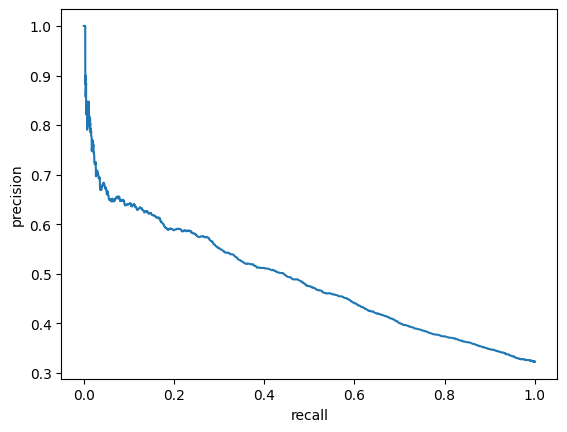

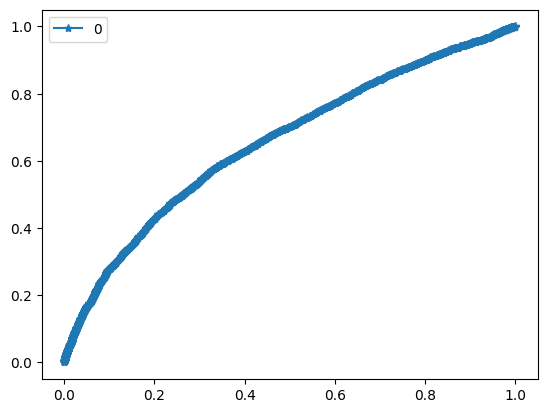

100%|██████████| 892/892 [02:42<00:00,  5.48it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.78635,0.738586,0.817297,0.654125,0.752086,0.578743


100%|██████████| 892/892 [02:40<00:00,  5.56it/s]


,train_loss,test_loss,auc,f1,recall,precision
1,0.724516,0.74012,0.81747,0.651802,0.72859,0.589657


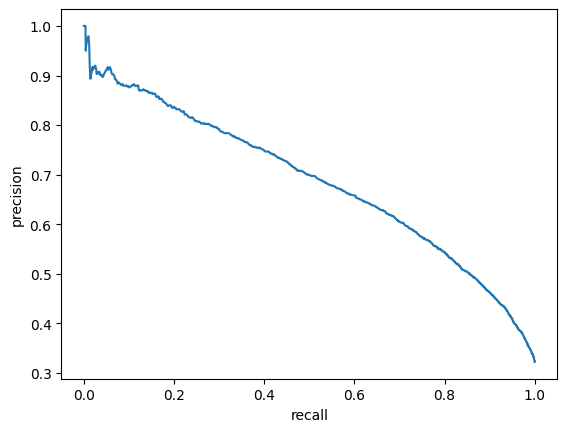

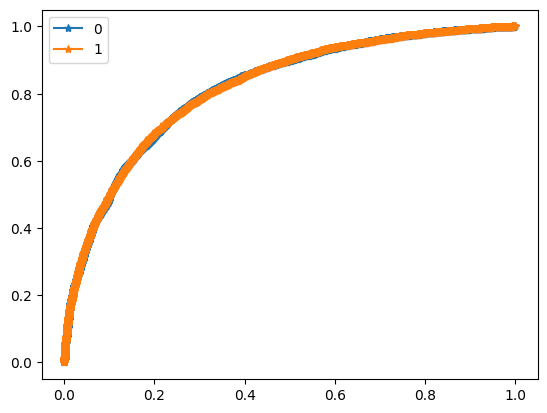

In [ ]:
w2v2dl_train = MultiDataLoader(w2v2_datasets_train, partial(create_dataloader, bs=16))
w2v2dl_valid = MultiDataLoader(w2v2_datasets_valid, partial(create_dataloader, bs=16))

w2v_training_config = TrainingConfig(
    fine_tune = True,
    device = device,
    model = W2V2Model(),
    train_dl = w2v2dl_train,
    valid_dl = w2v2dl_valid,
    optimizer = torch.optim.AdamW,
    weight_decay = 1,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 2,
    head_pretrain_epochs = 1,
    learning_rate = 1e-5,
    head_pretrain_learning_rate = 1e-3,
    mixed_precision = True,
    gradient_accumulation_size = 64
)

training = Training(w2v_training_config)

training.run()

# ViT

In [ ]:
spctr_dataset_train_fixed.prefetch(0.6)
spctr_dataset_valid_fixed.prefetch(0.6)

100%|██████████| 111/111 [00:44<00:00,  2.47it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.832366,0.810435,0.766863,0.60327,0.704875,0.527267


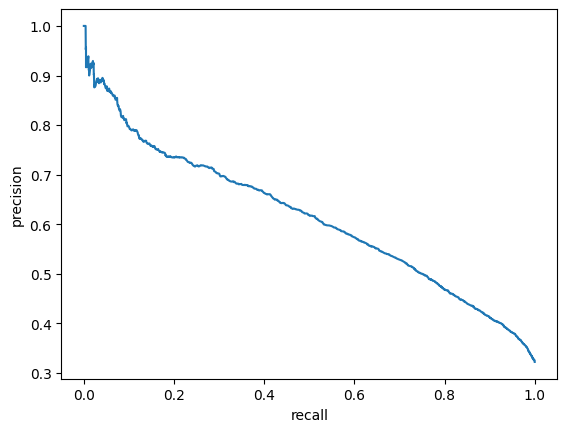

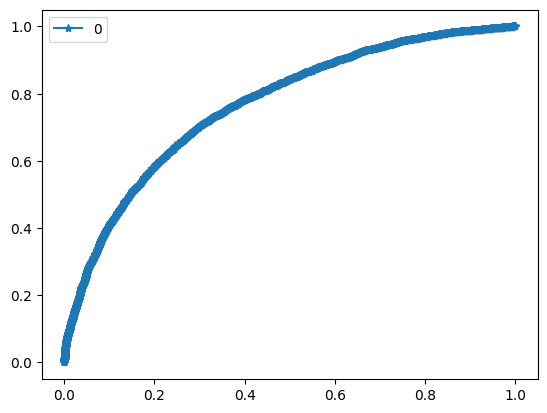

100%|██████████| 111/111 [00:44<00:00,  2.49it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.786857,0.841773,0.797649,0.628731,0.742424,0.545235


100%|██████████| 111/111 [00:44<00:00,  2.48it/s]


,train_loss,test_loss,auc,f1,recall,precision
1,0.751145,0.801809,0.796527,0.626177,0.74484,0.540127


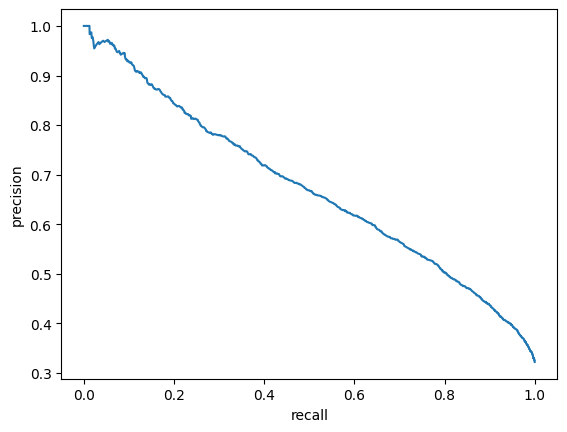

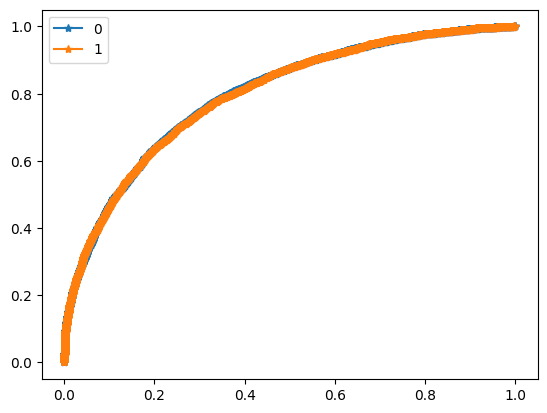

In [ ]:
from experiments.models import ViTModel

model = ViTModel(im_size=(mels, maxl),
                 name = 'deit_tiny_distilled_patch16_224',
                 dropout=0.3)

vit_training_config = TrainingConfig(
    fine_tune = True,
    device = device,
    model = model,
    train_dl = create_dataloader(spctr_dataset_train_fixed, bs=64),
    valid_dl = create_dataloader(spctr_dataset_valid_fixed, bs=64),
    optimizer = torch.optim.AdamW,
    weight_decay = 1,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 2,
    head_pretrain_epochs = 1,
    learning_rate = 1e-5,
    head_pretrain_learning_rate = 1e-3,
    mixed_precision = True
)

training = Training(vit_training_config)

training.run()

# Pretrained CNN

In [ ]:
for ds in chain(spctr_ds_train_binned,spctr_ds_valid_binned):
  ds.prefetch(1)

100%|██████████| 230/230 [00:11<00:00, 19.28it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.878943,0.907094,0.716213,0.571478,0.726834,0.470839


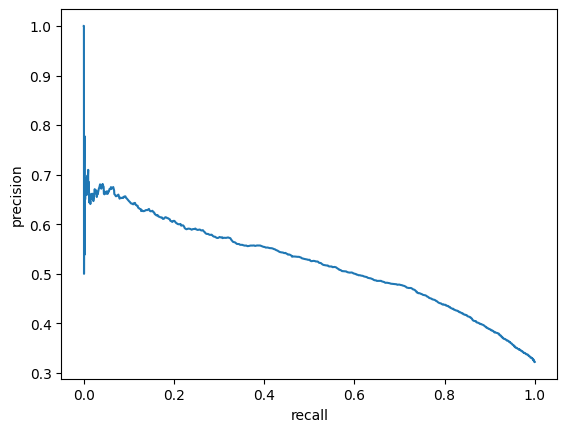

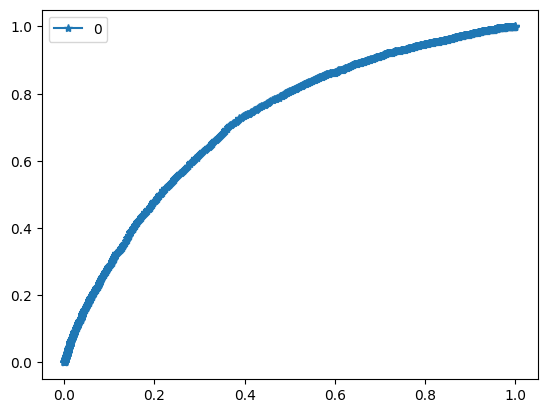

100%|██████████| 230/230 [00:12<00:00, 18.80it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.800668,0.803675,0.804821,0.641816,0.74484,0.56383


100%|██████████| 230/230 [00:12<00:00, 19.08it/s]


,train_loss,test_loss,auc,f1,recall,precision
1,0.762559,0.750714,0.811969,0.644576,0.741107,0.570294


100%|██████████| 230/230 [00:11<00:00, 19.31it/s]


,train_loss,test_loss,auc,f1,recall,precision
2,0.740888,0.757503,0.808494,0.640108,0.726834,0.571873


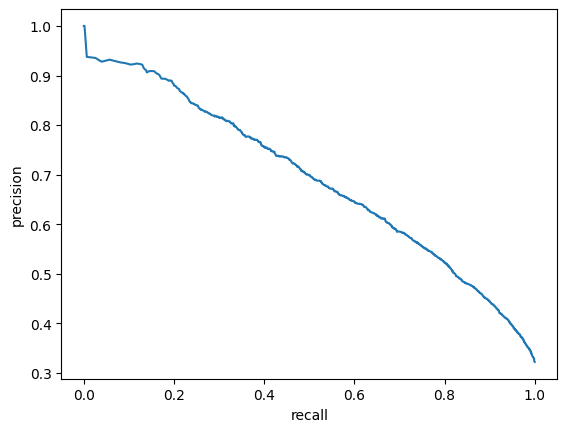

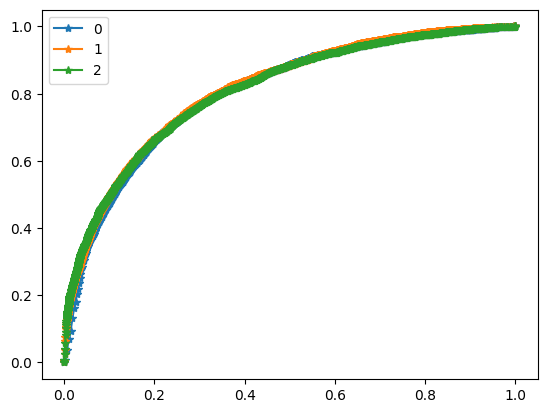

In [ ]:
model = ConvNextModel(name = 'convnext_tiny', dropout=0.2)

training_config = TrainingConfig(
    fine_tune = True,
    device = device,
    model = model,
    train_dl = MultiDataLoader(spctr_ds_train_binned, partial(create_dataloader, bs=64)),
    valid_dl = MultiDataLoader(spctr_ds_valid_binned, partial(create_dataloader, bs=64)),
    optimizer = torch.optim.AdamW,
    weight_decay = 4,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 3,
    learning_rate = 1e-4/2,
    head_pretrain_learning_rate = 1e-3,
    mixed_precision = True
)

training = Training(training_config)

training.run()

# Custom CNN Transformer

In [ ]:
from experiments.models import CustomConvTransformer

In [ ]:
for ds in chain(spctr_ds_train_binned,spctr_ds_valid_binned):
  ds.prefetch(1)

100%|██████████| 230/230 [00:07<00:00, 32.28it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.814238,0.773414,0.793025,0.624,0.719368,0.550959


100%|██████████| 230/230 [00:07<00:00, 31.47it/s]


,train_loss,test_loss,auc,f1,recall,precision
1,0.771719,0.758556,0.801348,0.633006,0.728151,0.559851


100%|██████████| 230/230 [00:06<00:00, 36.48it/s]


,train_loss,test_loss,auc,f1,recall,precision
2,0.753767,0.758195,0.802045,0.635189,0.73408,0.559779


100%|██████████| 230/230 [00:05<00:00, 40.80it/s]


,train_loss,test_loss,auc,f1,recall,precision
3,0.734888,0.754444,0.803696,0.635551,0.741546,0.556068


100%|██████████| 230/230 [00:06<00:00, 33.63it/s]


,train_loss,test_loss,auc,f1,recall,precision
4,0.725415,0.754049,0.802665,0.635757,0.731664,0.562078


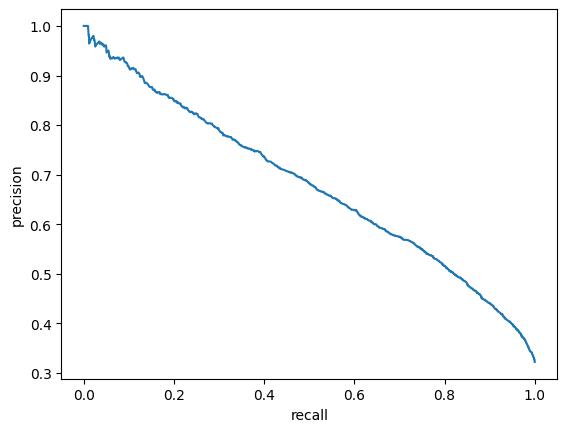

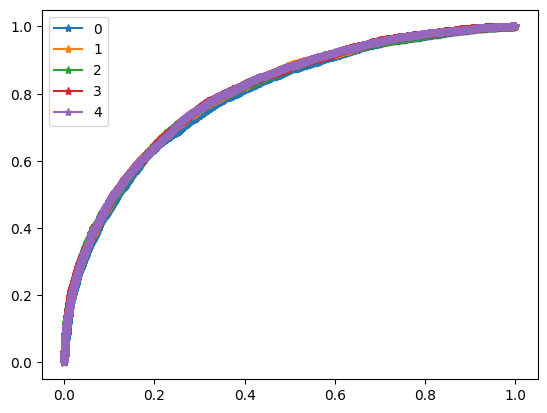

In [ ]:
from experiments.models import convolution_block, ResidualBlock

cnn = nn.Sequential(
        convolution_block(1,32),
        nn.MaxPool2d(2),
        ResidualBlock(32, 32),
        nn.MaxPool2d(2),
        ResidualBlock(32, 64),
        nn.MaxPool2d(2),
        ResidualBlock(64, 64),
        nn.MaxPool2d(2),
        ResidualBlock(64, 128),
        nn.MaxPool2d(2)
    )



training_config = TrainingConfig(
    fine_tune = False,
    device = device,
    model = CustomConvTransformer(cnn,conv_emb_dim=128,target_dim=256,layers=3),
    train_dl = MultiDataLoader(spctr_ds_train_binned, partial(create_dataloader, bs=64)),
    valid_dl = MultiDataLoader(spctr_ds_valid_binned, partial(create_dataloader, bs=64)),
    optimizer = torch.optim.AdamW,
    weight_decay = 3,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 5,
    learning_rate = 1e-4/2,
    mixed_precision = True
)

training = Training(training_config)

training.run()

# Errors analysis

In [17]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [35]:
errors_report =  pd.read_csv('errors_report.csv', index_col=0)
valid_data = pd.read_csv('valid_data_full.csv', index_col=0)
errors_report['errors'] = -np.log(np.where(errors_report.targ==1, errors_report.pred, 1-errors_report.pred))
errors_report = errors_report.set_index('id')

In [36]:
report = errors_report.join(valid_data)

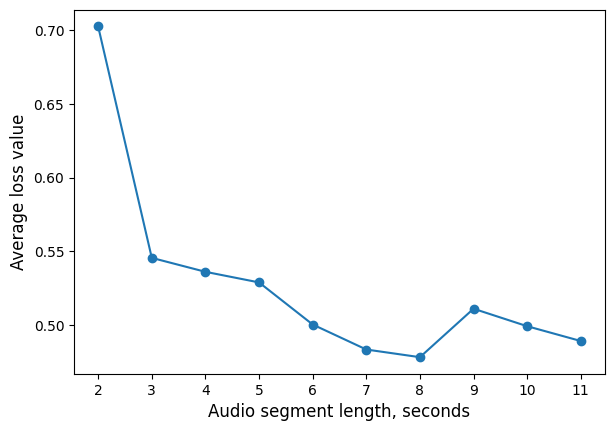

In [37]:
r1 = report.copy()
r1.dur = round(r1.dur).astype(int)
r1 = r1.groupby('dur').apply(lambda x: pd.Series({"cnt":len(x), "mean_loss":x['errors'].mean()}))
#_,ax = plt.subplots(1)
cm = 1/2.54  # centimeters in inches
_,ax = plt.subplots(figsize=(17.4*cm, 12*cm))
ax = r1['mean_loss'].plot(marker='o', ax=ax)
plt.ylabel('Average loss value',fontsize=12)
plt.xlabel('Audio segment length, seconds',fontsize=12)
ax.set_xticks([2,3,4,5,6,7,8,9,10,11])
plt.savefig(fname='lenloss', dpi=600)
#r1.cnt.plot.bar(rot=0,ax=ax[1])


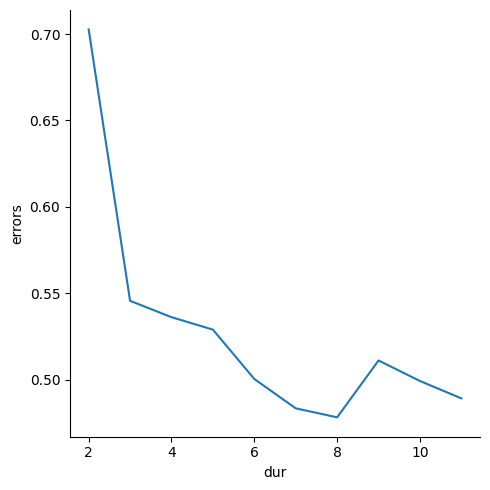

In [38]:
sns.relplot(data=report, x=round(report.dur), y='errors', kind="line", errorbar=None)

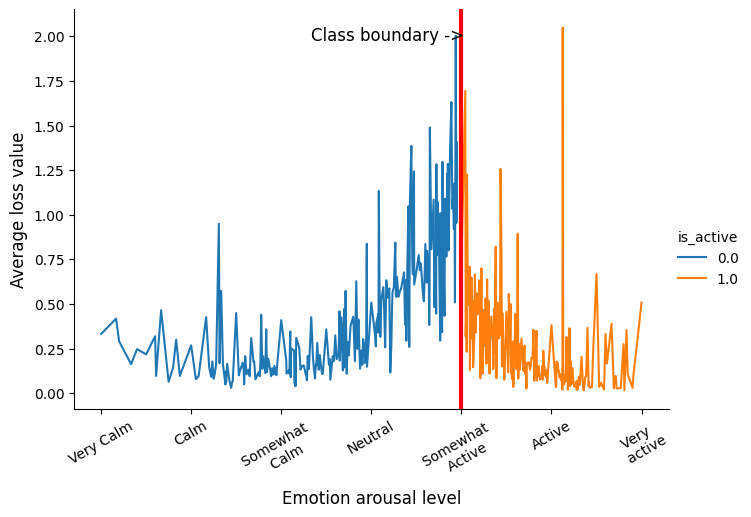

In [42]:
import seaborn as sns

cm = 1/2.54
sns.relplot(data=report, x="EmoAct", y="errors", kind="line", hue='is_active', errorbar=None,
            height=12*cm, aspect=(17.4/12))
ax = plt.gca()
ax.axvline(x=5, color='r', linewidth=3)
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(['Very Calm', 'Calm', 'Somewhat \n Calm', 'Neutral', 'Somewhat \n Active', 'Active', 'Very \n active'], rotation=30);
plt.xlabel('Emotion arousal level',fontsize=12)
plt.ylabel('Average loss value', fontsize=12)
plt.annotate("Class boundary ->", (4.18, 1.9),
                 xycoords="data",
                 textcoords="offset points",
                 xytext=(0, 10), ha="center", fontsize=12)
plt.savefig(fname='actloss2', dpi=600,bbox_inches='tight')


<Axes: xlabel='EmoAct', ylabel='errors'>

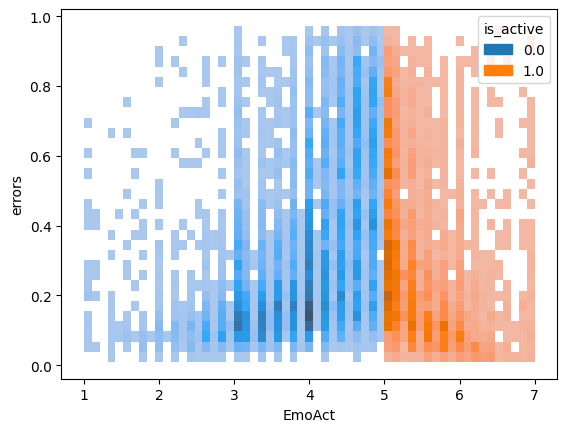

In [ ]:
sns.histplot(data=report, x="EmoAct", y="errors", hue='is_active')

<Axes: xlabel='EmoClass'>

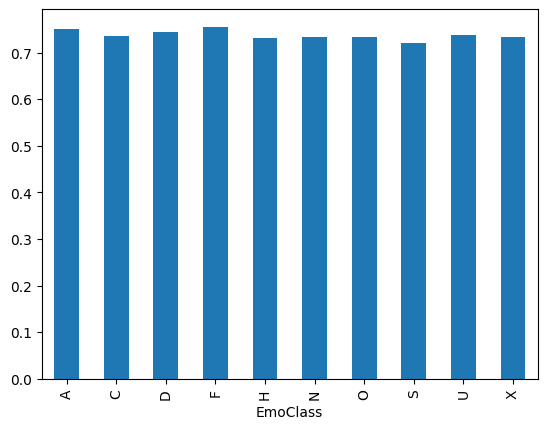

In [ ]:
report[report['errors'] > 0.6].groupby('EmoClass').apply(lambda x: x['errors'].mean()).plot.bar()